In [5]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd

In [6]:
df = pd.read_excel('1400.xlsx')

In [7]:
df['SMILES'].describe()

count                                                  1468
unique                                                 1380
top       C[N+](C)(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@...
freq                                                      4
Name: SMILES, dtype: object

In [8]:
df['SI'] = df['CC50-MDCK, mmg/ml']/df['IC50, mmg/ml']
df['S_leng'] = df['SMILES'].str.len ()

In [9]:
df.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0,35
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0,35
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0,39
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44


In [10]:
df.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures,S_leng
count,1468.000000,1468.000000,1.468000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000,1468.000000
mean,50.277063,186.491530,2.210854e+04,384.739636,3.831744,1.333787,81.273215,364.909216,62.997956
std,92.184768,1009.454293,4.771268e+05,153.164268,2.860473,1.803663,54.078778,210.154325,32.373175
min,0.000010,0.031928,3.616134e-02,110.157000,0.000000,0.000000,0.000000,1.000000,13.000000
25%,2.500000,30.375000,1.833333e+00,283.049250,2.000000,0.000000,39.440000,183.500000,46.000000
50%,10.100000,90.400000,5.528073e+00,349.371000,3.000000,1.000000,71.840000,365.000000,55.000000
75%,49.450000,300.000000,2.778741e+01,446.508000,5.000000,2.000000,106.160000,546.500000,68.000000
max,1000.000000,37646.000000,1.632222e+07,1159.380000,19.000000,11.000000,319.510000,728.000000,279.000000


In [11]:
df['Title'].size

1468

In [12]:
df = df[df.SI <= 100]

In [13]:
df = df[df['IC50, mmg/ml'] < 250]
df = df[df['CC50-MDCK, mmg/ml'] < 250]
df = df[df.S_leng < 120]
df = df[df.SI <= 100]

In [14]:
df = df[df.S_leng < 140]
df = df[df['IC50, mmg/ml'] < 310]

In [15]:
df.columns

Index(['Title', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'SMILES',
       'Pictures', 'S_leng'],
      dtype='object')

In [16]:
df_w = df[[ 'IC50, mmg/ml', 'SMILES']]

In [17]:
df_w.describe()

,"IC50, mmg/ml"
count,826.000000
mean,21.085836
std,29.285577
min,0.004219
25%,2.700000
50%,8.200000
75%,30.000000
max,200.000000


## Анализ данных

<Axes: xlabel='S_leng', ylabel='Count'>

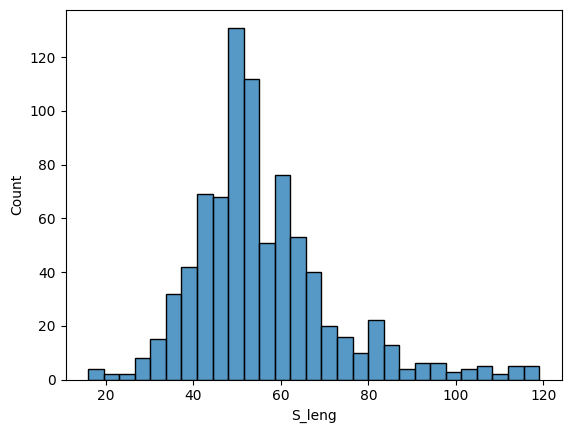

In [19]:
import seaborn as sns
sns.histplot(df['S_leng'])

<Axes: xlabel='IC50, mmg/ml', ylabel='Count'>

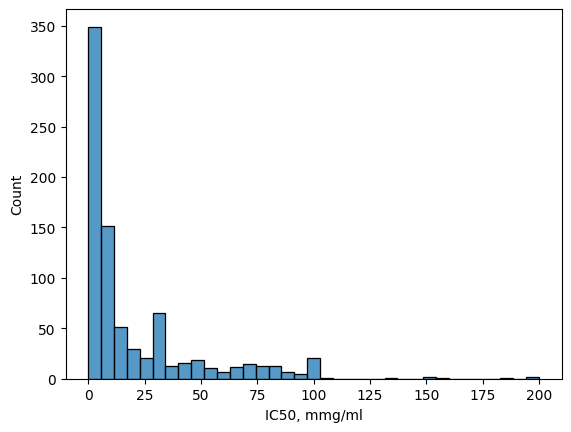

In [20]:
sns.histplot(df['IC50, mmg/ml'])

In [21]:
df[df['IC50, mmg/ml'] < 250]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures,S_leng
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0,41
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0,44
13,1018-As-105,13.5,73.0,5.407407,641.133,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,63.0,102
14,1019-YA-214,50.0,41.5,0.830000,472.674,6,0,77.32,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCOC(=O)CCC(=O...,64.0,82
15,1031-ОЛ7-144-1,6.4,53.0,8.281250,431.406,8,2,123.02,CC(=O)C(C1=O)=C(O)C=C2Oc(c3[C@@]12C)c4c(c(C)c3...,65.0,68
...,...,...,...,...,...,...,...,...,...,...,...
1409,CHEMBL5176004,199.1,199.1,1.000000,220.274,4,0,55.99,O=C1C[C@@H](CC2)C(C)(C)[C@]12c(on3)nc3C,NaN,39
1415,CHEMBL4294644,150.2,150.2,1.000000,154.254,1,1,20.23,C[C@]12C(C)(C)[C@@H](CC2)C[C@@H]1O,NaN,34
1429,CHEMBL154,3.7,230.3,62.243243,230.266,1,0,46.53,O=C(O)[C@@H](C)c(c1)ccc(c12)cc(cc2)OC,NaN,37
1448,CHEMBL3040734,29.1,176.3,6.058419,139.243,0,0,26.02,C[C@H](N)[C@H]([C@H]12)C[C@@H](C1)CC2,NaN,37


In [22]:
df_v = df[['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'S_leng']]

In [23]:
df_v = df_v[df_v.SI < 500]
df_v = df_v[df_v.S_leng < 140]

In [24]:
df_v.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,21.085836,62.008071,12.309207,360.474478,3.426150,1.157385,73.337324,55.915254
std,29.285577,56.648737,19.131256,108.146808,2.267022,1.388935,44.082755,16.143000
min,0.004219,0.031928,0.036161,139.243000,0.000000,0.000000,0.000000,16.000000
25%,2.700000,16.900000,1.663584,284.291750,2.000000,0.000000,38.770000,46.000000
50%,8.200000,43.350000,4.241162,345.306000,3.000000,1.000000,67.130000,53.000000
75%,30.000000,93.375000,13.098810,418.469250,4.000000,2.000000,99.330000,63.000000
max,200.000000,243.000000,100.000000,811.002000,14.000000,8.000000,270.280000,119.000000


<Axes: ylabel='Polar SA'>

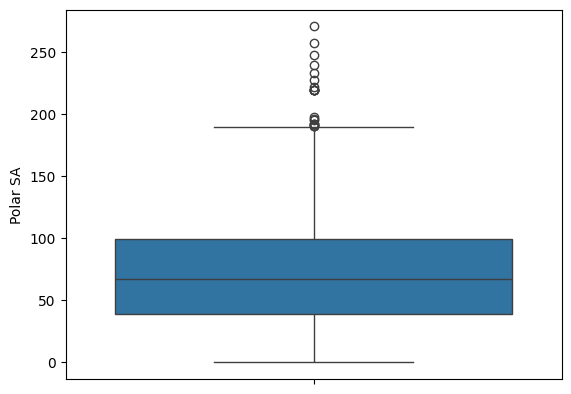

In [25]:
sns.boxplot(df['Polar SA'])

In [26]:
df_v.groupby('Hydrogen bond acceptors')['IC50, mmg/ml'].mean()

Hydrogen bond acceptors
0     11.600000
1     16.532906
2     20.490741
3     31.696894
4     21.559379
5     23.335304
6     14.037736
7      8.443087
8     16.074994
9     28.323778
10    11.583333
11    13.900000
12     4.350000
13     7.500000
14     1.700000
Name: IC50, mmg/ml, dtype: float64

In [27]:
df_v.groupby('Hydrogen bond donors')['IC50, mmg/ml'].mean()

Hydrogen bond donors
0    14.400772
1    29.043460
2    31.258481
3    15.385965
4     4.574572
5     4.916305
6     8.428571
7    17.633333
8     2.700000
Name: IC50, mmg/ml, dtype: float64

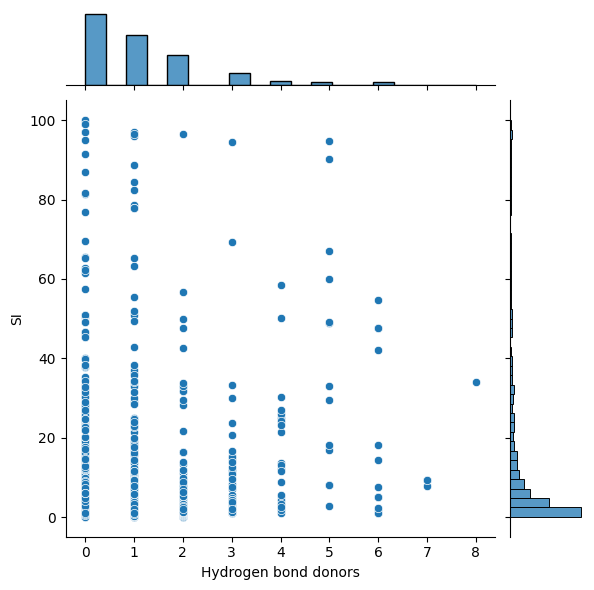

In [28]:
sns.jointplot(x='Hydrogen bond donors', y='SI', data=df_v);

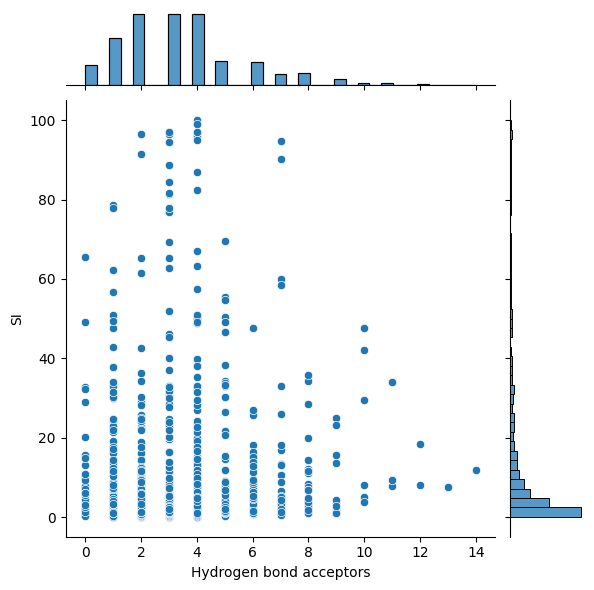

In [29]:
sns.jointplot(x='Hydrogen bond acceptors', y='SI', data=df_v);

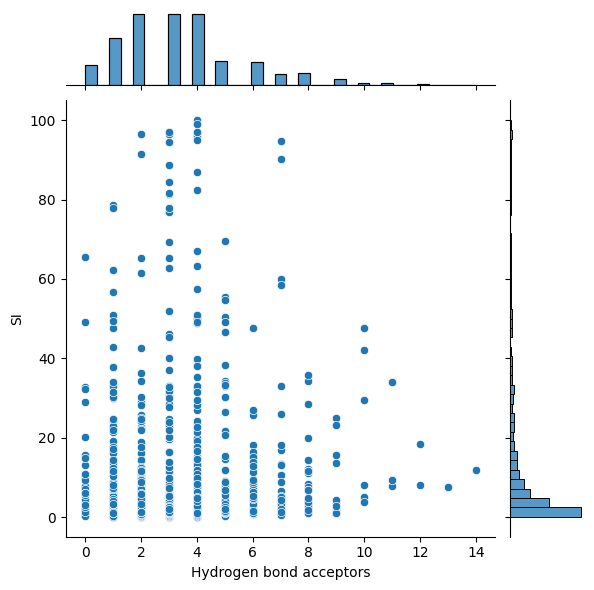

In [30]:
sns.jointplot(x='Hydrogen bond acceptors', y='SI', data=df_v);

In [31]:
df_v.corr()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
"IC50, mmg/ml",1.000000,0.490641,-0.353011,0.041513,-0.019716,0.002977,0.044862,-0.025524
"CC50-MDCK, mmg/ml",0.490641,1.000000,0.038287,-0.014109,0.014909,-0.017078,0.045552,0.019636
SI,-0.353011,0.038287,1.000000,-0.025821,0.033907,0.022420,0.014253,0.003325
Molecular weight,0.041513,-0.014109,-0.025821,1.000000,0.617577,0.299117,0.707083,0.771850
Hydrogen bond acceptors,-0.019716,0.014909,0.033907,0.617577,1.000000,0.497591,0.770873,0.487671
Hydrogen bond donors,0.002977,-0.017078,0.022420,0.299117,0.497591,1.000000,0.669975,0.277980
Polar SA,0.044862,0.045552,0.014253,0.707083,0.770873,0.669975,1.000000,0.526978
S_leng,-0.025524,0.019636,0.003325,0.771850,0.487671,0.277980,0.526978,1.000000


## Векторайзер

In [ ]:
OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2

In [32]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

c:\Users\po6wi\AppData\Local\Programs\Python\Python311\Lib\site-packages\rdkit\Chem\PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x00000206311...
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x00000206311...
13,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,<rdkit.Chem.rdchem.Mol object at 0x00000206311...
14,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCOC(=O)CCC(=O...,<rdkit.Chem.rdchem.Mol object at 0x00000206311...
15,CC(=O)C(C1=O)=C(O)C=C2Oc(c3[C@@]12C)c4c(c(C)c3...,<rdkit.Chem.rdchem.Mol object at 0x00000206311...
...,...,...
1409,O=C1C[C@@H](CC2)C(C)(C)[C@]12c(on3)nc3C,<rdkit.Chem.rdchem.Mol object at 0x0000020634F...
1415,C[C@]12C(C)(C)[C@@H](CC2)C[C@@H]1O,<rdkit.Chem.rdchem.Mol object at 0x0000020634F...
1429,O=C(O)[C@@H](C)c(c1)ccc(c12)cc(cc2)OC,<rdkit.Chem.rdchem.Mol object at 0x0000020634F...
1448,C[C@H](N)[C@H]([C@H]12)C[C@@H](C1)CC2,<rdkit.Chem.rdchem.Mol object at 0x0000020634F...


In [34]:
from molvecgen.vectorizers import SmilesVectorizer

In [35]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

In [36]:
print(smivec.charset)
smivec.dims

oF1[Crcn(]4+l2@BS)\-i6eOsH5NI=P/3#^$?


(116, 37)

In [43]:
print("Maximum allowed SMILES length %s"%smivec.maxlength)

Maximum allowed SMILES length 115


In [44]:
y = df_w['IC50, mmg/ml'].values.reshape((-1,1))
X = df_w.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [46]:
y_train

array([[ 3.97020321e-01],
       [-4.51173156e-01],
       [ 2.90996136e-01],
       [-7.58643292e-01],
       [-7.30370176e-01],
       [ 2.11107797e+00],
       [-5.21855946e-01],
       [-7.65711571e-01],
       [ 4.73083779e-03],
       [-7.16233618e-01],
       [-7.58643292e-01],
       [-5.04185248e-01],
       [ 5.06578645e-01],
       [-4.90048690e-01],
       [-4.51173156e-01],
       [-5.67799759e-01],
       [-6.24345991e-01],
       [ 4.04088600e-01],
       [-6.31414270e-01],
       [-6.10209433e-01],
       [-6.98562920e-01],
       [ 8.74129152e-01],
       [-7.58643292e-01],
       [-7.19767757e-01],
       [ 1.13565547e+00],
       [-5.35992504e-01],
       [ 2.91686178e+00],
       [-9.77592074e-02],
       [ 1.60232975e-01],
       [-5.14787667e-01],
       [-6.98562920e-01],
       [-7.23301897e-01],
       [-7.19767757e-01],
       [-3.98161064e-01],
       [-6.59687386e-01],
       [-7.16233618e-01],
       [-1.82578555e-01],
       [-4.15831761e-01],
       [-7.4

In [47]:
from pprint import pprint

In [48]:
y_train.shape

(495, 1)

In [49]:
y_test.shape

(207, 1)

In [50]:
y_validation.shape

(124, 1)

In [53]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [54]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[78]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-0.72683604]))

In [56]:
torch.cuda.is_available()

True

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

cuda:0


torch.Size([124, 116, 37])

In [57]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size//2) # Output layer
        self.activation2 = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(x) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.fc2(out) # Pass into the hidden layer
        out = self.activation2(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

epochs = 400
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.4 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.005  # The initial learning rate for the optimizer

In [58]:
epochs = 100
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.3 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.01  # The initial learning rate for the optimizer

In [59]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

c:\Users\po6wi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): GRU(37, 32, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [60]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[0.2186]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

In [ ]:
for smiles, labels in train_loader:
    print(smiles)
    print(labels)
    break

In [ ]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = torch.tensor(smiles, device=device).float()
        #print(smiles)
        labels = torch.tensor(labels, device=device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


<ipython-input-63-37434c2c50fc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smiles = torch.tensor(smiles, device=device).float()
<ipython-input-63-37434c2c50fc>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device).float()


Epoch 5, Training loss: 1.01 Validation loss: 0.98
Epoch 10, Training loss: 1.04 Validation loss: 0.99
Epoch 15, Training loss: 1.00 Validation loss: 0.98
Epoch 20, Training loss: 1.02 Validation loss: 0.95
Epoch 25, Training loss: 0.93 Validation loss: 0.94
Epoch 30, Training loss: 0.96 Validation loss: 0.94
Epoch 35, Training loss: 0.95 Validation loss: 0.93
Epoch 40, Training loss: 0.92 Validation loss: 0.96
Epoch 45, Training loss: 0.96 Validation loss: 0.94
Epoch 50, Training loss: 1.01 Validation loss: 0.92
Epoch 55, Training loss: 1.06 Validation loss: 0.95
Epoch 60, Training loss: 0.96 Validation loss: 0.93
Epoch 65, Training loss: 0.96 Validation loss: 0.92
Epoch 70, Training loss: 0.95 Validation loss: 0.90
Epoch 75, Training loss: 0.91 Validation loss: 0.90
Epoch 80, Training loss: 0.86 Validation loss: 0.88
Epoch 85, Training loss: 0.93 Validation loss: 0.85
Epoch 90, Training loss: 0.93 Validation loss: 0.88
Epoch 95, Training loss: 0.86 Validation loss: 0.87
Epoch 100, Tr

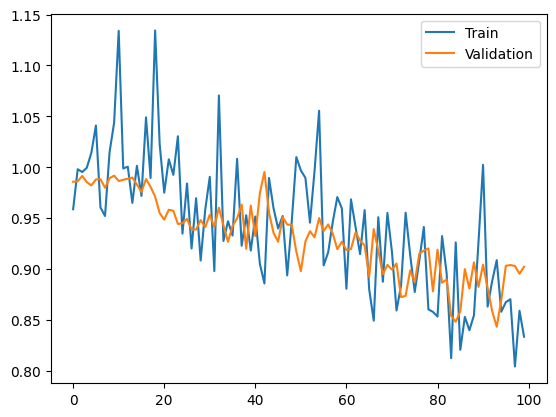

In [ ]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [ ]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)


In [ ]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.9020845293998718

In [ ]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))

In [ ]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.826	Test RMSE: 0.765


In [ ]:
y_pred_train.shape

torch.Size([1, 684, 1])

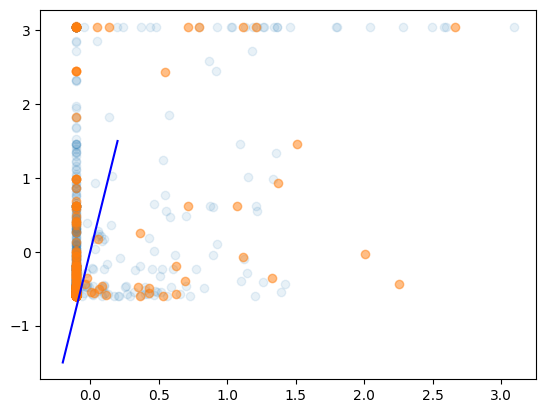

In [ ]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-0.2, 0.2], [-1.5,1.5], c="b")
#plt.xlim(-1,  1)
#plt.ylim(-0.1,  1)